In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import anndata as an
import scanpy as sc
import scipy
from importlib import reload
from transformers import BertConfig, BertForMaskedLM, AdamW, DataCollatorForLanguageModeling
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, TensorDataset

# local imports
source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import matrix as matrix
import centrality as central

# bert model stuff
import basic_bert

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get input

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


read_code,65057,21695,119867,7453,65998,81009,110088,18720,89300,115287,...,47296,6202,3069,97901,6136,88389,111230,69764,94327,2373
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Tokenize

In [3]:
max_length = 26
bin_names = df.T.columns.astype(int).to_numpy()

tokens = df.T.apply(lambda x: bin_names[np.argwhere(x != 0).ravel()], axis=1)
tokens = tokens.reset_index()
tokens.columns = ['read_code', 'raw_input']
tokens['order'] = tokens['raw_input'].apply(lambda x: len(x))
tokens['input_ids'] = tokens['raw_input'].apply(lambda x: basic_bert.format_input(x, max_length=max_length))
tokens['length'] = tokens['input_ids'].apply(lambda x: len(x))
tokens.head()

,read_code,raw_input,order,input_ids,length
0,65057,"[31, 41, 42, 43, 62, 63, 64, 82]",8,"[31, 41, 42, 43, 62, 63, 64, 82, 0, 0, 0, 0, 0...",26
1,21695,"[71, 73, 127, 180]",4,"[71, 73, 127, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26
2,119867,"[8, 183]",2,"[8, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",26
3,7453,"[100, 111, 119]",3,"[100, 111, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26
4,65998,"[145, 169]",2,"[145, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26


In [4]:
data_loader = basic_bert.prepare_bert_dataloader(tokens, batch_size=500)

Shape of input_ids: torch.Size([122676, 26])
Data type of input_ids: torch.int64
Device of input_ids: cpu
First 10 values in input_ids: tensor([[ 31,  41,  42,  43,  62,  63,  64,  82,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 71,  73, 127, 180,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  8, 183,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [100, 111, 119,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [145, 169,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [102, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  

# Build the model

In [5]:
reload(basic_bert)
# Clear GPU cache (if available)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
vocab_size = 200
output_shape = 30

pore_bert = basic_bert.BasicBert(
    vocab_size=vocab_size,
    max_length=max_length,
)

pore_bert.build(output_shape=output_shape)

Model Built!


# Train the model

In [6]:
num_epochs = 50
learning_rate = 1e-4
verbose = True

pore_bert.train(
    data_loader=data_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    verbose=verbose,
)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/50, Total Loss: 1110.66
Epoch 2/50, Total Loss: 703.07
Epoch 3/50, Total Loss: 362.98
Epoch 4/50, Total Loss: 204.97
Epoch 5/50, Total Loss: 148.94
Epoch 6/50, Total Loss: 121.39
Epoch 7/50, Total Loss: 111.33
Epoch 8/50, Total Loss: 104.79
Epoch 9/50, Total Loss: 101.17
Epoch 10/50, Total Loss: 98.64
Epoch 11/50, Total Loss: 96.76
Epoch 12/50, Total Loss: 95.69
Epoch 13/50, Total Loss: 95.22
Epoch 14/50, Total Loss: 94.52
Epoch 15/50, Total Loss: 92.82
Epoch 16/50, Total Loss: 92.58
Epoch 17/50, Total Loss: 92.02
Epoch 18/50, Total Loss: 92.36
Epoch 19/50, Total Loss: 92.31
Epoch 20/50, Total Loss: 91.64
Epoch 21/50, Total Loss: 91.42
Epoch 22/50, Total Loss: 90.76
Epoch 23/50, Total Loss: 89.93
Epoch 24/50, Total Loss: 90.40
Epoch 25/50, Total Loss: 89.91
Epoch 26/50, Total Loss: 90.25
Epoch 27/50, Total Loss: 89.29
Epoch 28/50, Total Loss: 90.29
Epoch 29/50, Total Loss: 88.18
Epoch 30/50, Total Loss: 86.85
Epoch 31/50, Total Loss: 87.55
Epoch 32/50, Total Loss: 86.43
Epoch 3

In [7]:
# break

# Extract Embeddings

In [8]:
sample_size = 10000
sample = tokens.sample(sample_size)

new_input = torch.tensor(sample['input_ids'].to_list())
print(f"{new_input.shape=}")

embeddings = pore_bert.get_embeddings(new_input)
print(f"{embeddings.shape=}")

sample.head()

new_input.shape=torch.Size([10000, 26])
embeddings.shape=torch.Size([10000, 26, 30])


,read_code,raw_input,order,input_ids,length
117988,58380,"[118, 171]",2,"[118, 171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26
72597,73950,"[177, 178]",2,"[177, 178, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26
112088,88105,"[99, 148]",2,"[99, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",26
1943,42057,"[16, 70]",2,"[16, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",26
109952,6054,"[4, 5, 89]",3,"[4, 5, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26


In [9]:
result = []

for i, (_, row) in enumerate(sample.iterrows()):
    n = min(row['order'], max_length)
    bins = row['raw_input'][:n] # handle raw inputs larger than the max length

    mat = embeddings[i, 0:n, :].cpu().detach().numpy()
    
    if not len(mat) == len(bins):
        print(f"{n=} {mat.shape=} {bins.shape=}")
        
    mat = pd.DataFrame(mat, index=bins)
    result.append(mat)

result = pd.concat(result)
result = result.reset_index(names='loci')

# average ovber the loci embeddings
result = result.groupby('loci').mean()

result.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
loci,,,,,,,,,,,,,,,,,,,,,
4,-1.183757,-0.721146,0.306001,-2.220211,-0.166637,-0.885444,0.619433,-0.131166,0.681763,-1.122260,...,1.340163,0.051400,-0.061632,0.161467,0.836247,-0.451279,1.438657,0.222476,0.052155,1.205917
5,-0.718891,-0.893462,0.609495,-1.615360,-0.291228,-0.911121,0.518449,-0.236205,0.316401,-0.861458,...,1.423984,0.333272,0.170634,0.040929,0.702479,-0.620358,1.411888,0.046287,0.109679,1.484500
6,-0.734764,-0.710752,0.398247,-1.684753,0.184878,-0.786532,0.548974,-0.447681,0.199642,-0.988761,...,1.106882,0.452623,0.165722,-0.015023,0.742998,-0.617658,1.273054,0.277895,0.183305,1.512839
7,-0.779208,-0.957498,0.354189,-1.680973,0.103665,-0.792673,0.488320,-0.198016,0.304349,-0.968155,...,1.287785,0.609368,0.219341,0.121935,0.856867,-0.621427,1.471454,0.056272,0.109273,1.349618
8,-0.777026,-0.947116,0.425893,-1.550415,0.062251,-0.467527,0.443295,-0.379488,0.174257,-1.037041,...,1.369753,0.619775,0.304835,-0.134192,0.840019,-0.578474,1.516581,0.062432,0.206255,1.220098


In [10]:
# Create AnnData object
adata = an.AnnData(
    X=result,
)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

print('done!')

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


done!


/tmp/ipykernel_814089/1809606138.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


In [11]:
A = matrix.clique_expand_incidence(df, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

A = matrix.normalize_oe(matrix.normalize_kr(A).todense())
A = np.asarray(A)

print(f"{A.shape=}")

pca = PCA(n_components=2)
pca.fit(A)
X_pca = pca.transform(A)
print('done!')

/home/cstansbu/git_repositories/higher-order-single-cell/source/matrix.py:290: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = np.divide(matrix, toeplitz_matrix)


A.shape=(193, 193)
done!


Text(0.5, 1.0, 'Correlation with A/B Compartment Scores')

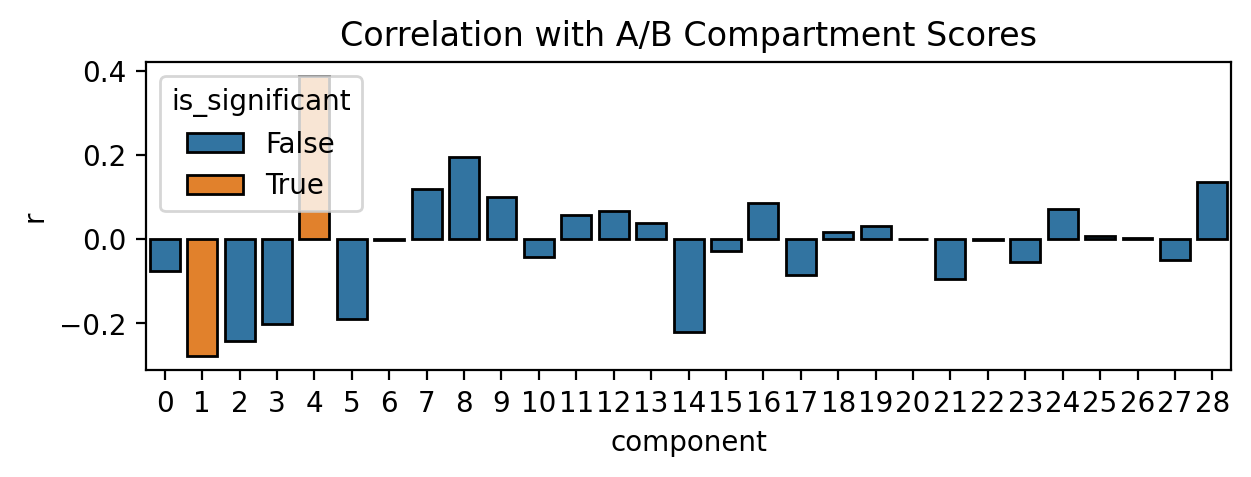

In [12]:
corr = []

for i in range(adata.obsm['X_pca'].shape[1]):
    vector = adata.obsm['X_pca'][:, i]
    r, pval = scipy.stats.pearsonr(X_pca[:, 0], vector)
    
    row = {
        'component' : i,
        'r' : r,
        'r_abs' : np.abs(r),
        'pval' : pval,
        'is_significant' : True if pval < 0.0001 else False,
    }
    
    corr.append(row)
    
corr = pd.DataFrame(corr)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 2

sns.barplot(data=corr,
            x='component',
            y='r',
            ec='k',
            hue='is_significant',
           )

plt.title('Correlation with A/B Compartment Scores')

# Plot top component

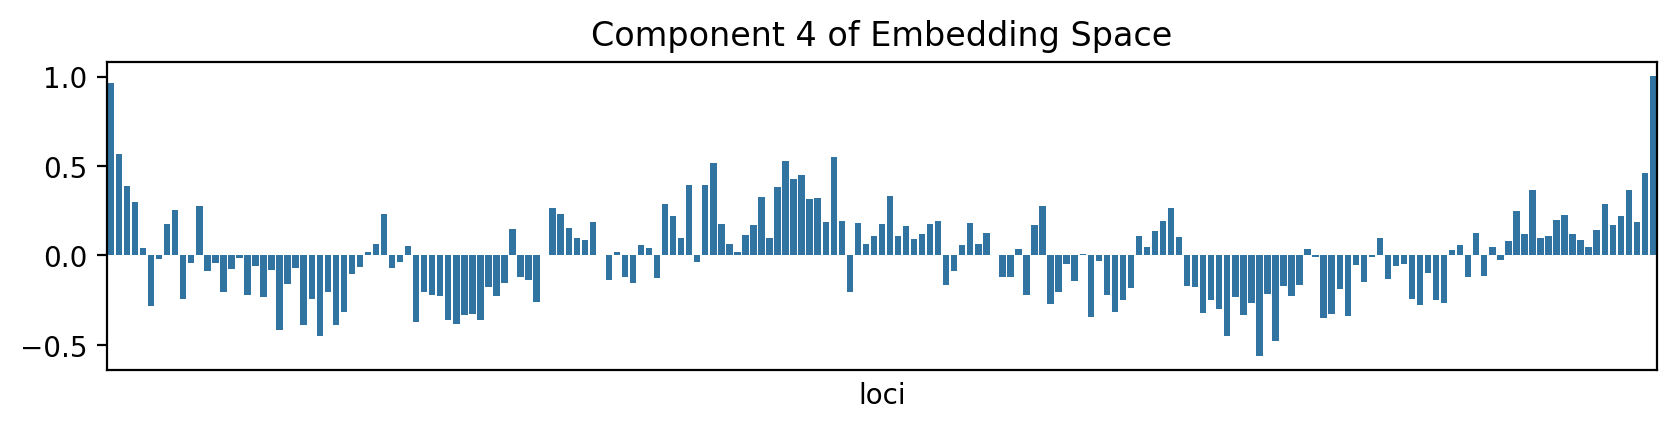

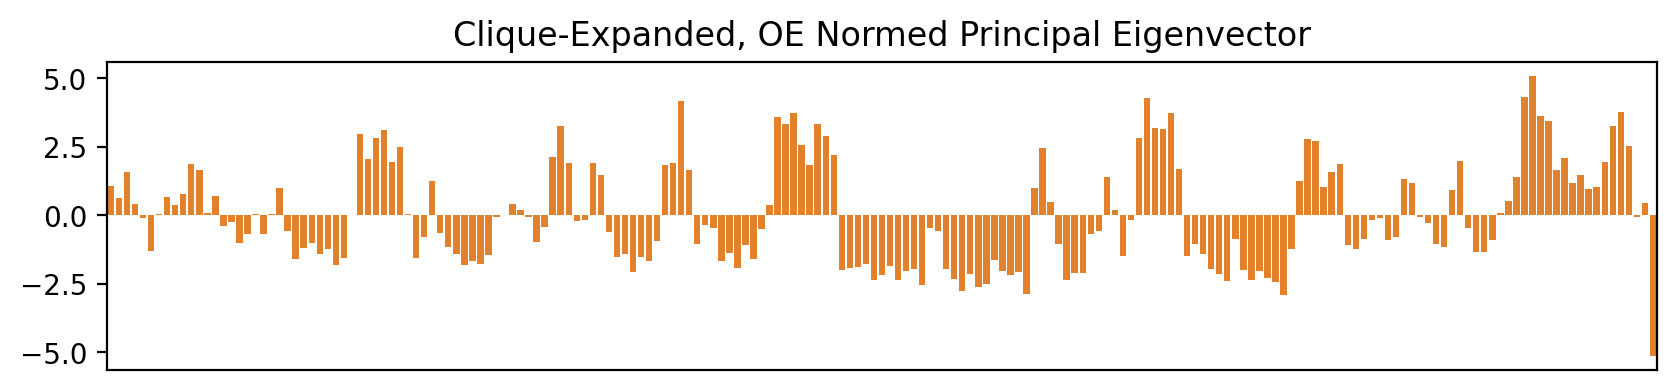

In [13]:
corr = corr.sort_values(by='r_abs', ascending=False)
top_component = corr['component'].values[0]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2


sns.barplot(x=adata.obs_names.astype(int),
            y=adata.obsm['X_pca'][:, top_component],
            )

plt.title(f"Component {top_component} of Embedding Space")
plt.xticks([])
plt.show()


sns.barplot(x=range(len(X_pca)),
            y=X_pca[:, 0],
            color='C1')

plt.title("Clique-Expanded, OE Normed Principal Eigenvector")

plt.xticks([])
plt.show()

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)